## Reading the data

In [1]:
from zipfile import ZipFile
import json
import collections
import numpy as np
from keras.utils import to_categorical
from keras.layers import TimeDistributed, Dense, Activation, Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from matplotlib import pyplot as plt

%matplotlib inline

DATA_FILE = '../data/0.zip'

Using TensorFlow backend.


Our data consists of legal documents that have been pre-processed, tokenized and tagged. They're stored in one zip file of JSON files. To save space we'll read the files directly from the zip.
Let's see what one of them looks like.

In [ ]:
with ZipFile(DATA_FILE) as z:
    filename = z.filelist[0]
    with z.open(filename) as f:
        content = json.load(f)
        print(*content, sep="\n")

We can see that the document is split into lines (sequences) made of (token, tag) pairs. For instance, the tokens 'execution' and 'version' (3rd line) are tagged with 'b' indicating that they are **bold**.

Next, we'll concatenate all of these sequences into one big dataset.  
**NOTE**: Due to memory/time constraints we will limit the number of documents we use for training.

In [3]:
def read_json_zip_file(input_file, read_limit=1000):
    with ZipFile(input_file) as z:
        all_x = []
        for fname in z.filelist[:read_limit]:
            with z.open(fname) as f:
                all_x += json.load(f)
    return all_x

In [4]:
sequences = read_json_zip_file(DATA_FILE)

Since our RNN will work on sequences, we need to determine the maximum sequence length we'll use. The length of the sequence will impact the memory our model uses and the time it takes to train it.   
We'll choose a maximum sequence length of 256 so that almost 98% of our data will be used in the model.

In [5]:
def filter_sequences(sequences, max_length=256):
    lengths = [len(x) for x in sequences]
    print(f'Maximum length: {max(lengths)}')
    print(f'Minimum length: {min(lengths)}')
    print(f'Average length: {sum(lengths)/len(lengths)}')
    
    short_sequences = [s for s in sequences if len(s) <= max_length]
    print(f'% of short sequences: {100 * len(short_sequences)/len(sequences)}')
    X = [[c[0] for c in x] for x in short_sequences]
    y = [[c[1] for c in y] for y in short_sequences]
    
    return X, y

In [6]:
max_length = 256
X, y = filter_sequences(sequences, max_length)

Maximum length: 4265
Minimum length: 1
Average length: 35.93670324570742
% of short sequences: 97.88135014877297


## Encoding the sequences

Now that we have our word sequences ready we need to represent them in a machine readable (=numerical) format. To do that, we'll merge all of the tokens into one big corpus and assign each token a unique number.  
**NOTE**: We will remove words that appear less than `min_token_frequency` since we can't learn much from them.

In [7]:
min_token_frequency = 2
corpus = (token for sequence in X for token in sequence)

## Reserve the first two indexes for padding and uknowns
index2token = ["{pad}", "{unk}"] + [token for token, count in collections.Counter(corpus).items() if count >= min_token_frequency]
token2index = collections.defaultdict(lambda: 1, {token: index for index, token in enumerate(index2token)})

index2label = ["{pad}"] + list(set([label for target in y for label in target]))
label2index = {label: index for index, label in enumerate(index2label)}

with open('../model/model_params.json', 'w') as file:
    json.dump({
        "word2ind": dict(token2index),
        "label2ind": dict(label2index),
        "max_length": max_length
    }, file)

Let's see some stats about our data

In [8]:
max_sequence_length = max([len(x) for x in X])

print('Text vocabulary size: ', len(token2index))
print('Label vocabulary size: ', len(label2index))
print('Maximum sequence length: ', max_sequence_length)

Text vocabulary size:  23507
Label vocabulary size:  6
Maximum sequence length:  256


Next, we will use the dictionaries we've just created to encode our data.  
**NOTE**: We pad our data so that each sample we feed our network has the same size. (This is not necessarily required but it improves Keras' perfromance)

In [9]:
X_enc = [[token2index[token] for token in sequence] for sequence in X]
max_label = len(label2index)
y_enc = [[0] * (max_sequence_length - len(target)) + [label2index[label] for label in target] for target in y]
y_enc = [to_categorical(target, max_label) for target in y_enc]

X_enc = pad_sequences(X_enc, maxlen=max_sequence_length)
y_enc = pad_sequences(y_enc, maxlen=max_sequence_length)

The last step in preparing the data is to split it into train/test set which we will later feed into our model.

In [10]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=test_size)

## Building the model

Before building our model, let's define some parameters which we'll need later

In [11]:
vocabulary_size = len(token2index)
tags_size = len(label2index)
embedding_size = 128
hidden_size = 32
batch_size = 2048
epochs = 3

To build our LSTM RNN, we're going to use Keras. We'll build it one layer at a time, explaining each layer as we go.  
The first layer is the input layer which will be given the `X_train` values we created previously. The shape of the layer is determined by the `max_sequence_length` we set earlier.

In [12]:
l_input = Input(shape=(max_sequence_length,))

Next, we create the embedding layer. This layer takes our numerical representation of tokens and learns a (hopefully) meaningful embedding for each of them. The input dimension for this layer is determined by the size of our vocabulary while the output dimension (embedding size) is chosen arbitrarily. We set `mask_zero=True` to let the network know that an input value of 0 is a padding value.

In [13]:
l_embed = Embedding(vocabulary_size, embedding_size, input_length=max_sequence_length, mask_zero=True)(l_input)   

Now we define our LSTM layer which will transform the vector sequence into a single vector of size `hidden_size`. We set `return_sequences` to `True` since we want to access the hidden state at each time step and feed that to to a `Dense` output layer wrapped in a `TimeDistributed` layer. (See more here: https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

In [14]:
l_lstm = LSTM(hidden_size, return_sequences=True)(l_embed)

We add a `Dense` layer with the size of `tags_size` - the number of tags we want to predict, wrapped in a `TimeDistributed` wrapper.

In [15]:
l_dense = TimeDistributed(Dense(tags_size))(l_lstm)

Finally we add the `Activation` layer with a softmax function to determine the tag of each token.

In [16]:
l_active = Activation('softmax')(l_dense)

Now we can create and compile the model using categorical crossentropy for our loss function.

In [17]:
model = Model(inputs=l_input, outputs=l_active)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

We can see what the model looks like by printing its summary

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 128)          4120448   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 32)           20608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 256, 6)            198       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 6)            0         
Total params: 4,141,254
Trainable params: 4,141,254
Non-trainable params: 0
_________________________________________________________________


## Training the model

Let's fit the model using the training data (this might tke a while depending on your hardware)

In [19]:
r = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 215141 samples, validate on 71714 samples
Epoch 1/3
215141/215141 [==============================] - 748s 3ms/step - loss: 0.5263 - acc: 0.9383 - val_loss: 0.2425 - val_acc: 0.9492
Epoch 2/3
215141/215141 [==============================] - 1123s 5ms/step - loss: 0.2257 - acc: 0.9491 - val_loss: 0.2179 - val_acc: 0.9477
Epoch 3/3
215141/215141 [==============================] - 1238s 6ms/step - loss: 0.2025 - acc: 0.9483 - val_loss: 0.1954 - val_acc: 0.9463


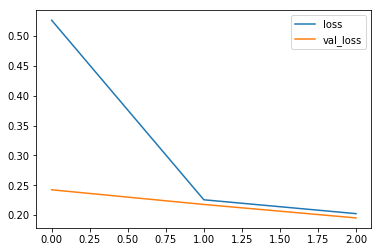

In [20]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

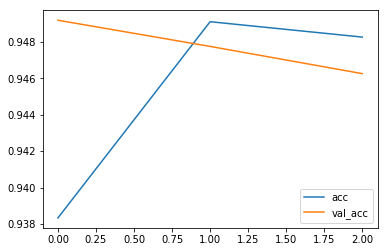

In [21]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()

## Evaluating the model

We will use several techniques to evaluate the results of our model. The first one is simply to use Keras's built-in `evaluate` function which will return the test loss - lower means better.

In [22]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Model loss: {score}')

71714/71714 [==============================] - 91s 1ms/step
Model loss: [0.19537902487086636, 0.9462510473866416]


The next metrics we'll look at are the accuracy and confusion matrix

In [23]:
## Takes our sequence predictions/true values and returns them as lists 
def reshape_predictions(yh, pr):
    coords = [np.where(yhh > 0)[0][0] for yhh in yh]
    yh = [yhh[co:] for yhh, co in zip(yh, coords)]
    ypr = [prr[co:] for prr, co in zip(pr, coords)]
    fyh = [c for row in yh for c in row]
    fpr = [c for row in ypr for c in row]
    return fyh, fpr

In [24]:
y_pred = model.predict(X_train).argmax(2)
yh = y_train.argmax(2)
fyh, fpr = reshape_predictions(yh, y_pred)
print('Training accuracy:', accuracy_score(fyh, fpr))
print('Training confusion matrix:')
print(confusion_matrix(fyh, fpr))

Training accuracy: 0.9471513091347475
Training confusion matrix:
[[      0       0       0       0       0       0]
 [   1228    3472    2815    1663  110542     181]
 [    222     282    5024     437  124579      11]
 [      0       0       0       0    1099       0]
 [    873    2038   15429    7682 5790233     147]
 [   1646     279    1721    1105   49586     185]]


Our accuracy is fairly high which is what we want but it might also indicate that our model isn't doing what we think it's doing. The accuracy metric measures the percentage of correct predictions. So, in our case, 95% if our tokens were marked as 'n' and 5% as any other label then if our model predicted 'n' for **all** input it would have an accuracy of 95%.  
Looking at the confusion matrix helps us gain insight as to what kind of errors our model makes. The columns of the matrix represent the prediction made by the model while the rows represent the true value - numbers on the diagonal are correct predicitions.  

Using the confusion matrix is sometimes difficult when comparing between different models/model parameters especially when there are a lot of classes. Looking at the precision, recall and F1 score might be easier 

In [25]:
results = precision_recall_fscore_support(fyh, fpr)
print(f'Precision: {results[0][1:]}')
print(f'Recall:    {results[1][1:]}')
print(f'F1-Score:  {results[2][1:]}')
print(f'Support:   {results[3][1:]}')

Precision: [0.57189919 0.20104846 0.         0.95296179 0.35305344]
Recall:    [0.02895722 0.03848187 0.         0.99550083 0.00339313]
F1-Score:  [0.05512336 0.06459908 0.         0.97376695 0.00672165]
Support:   [ 119901  130555    1099 5816402   54522]


c:\users\ugore\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


We see that for label 4 ('n') we get good values across all metrics whereas for other labels we do rather poorly. This doesn't necessarily mean that our model isn't good - it really depends on what and how we're going to use it.

Up until now we've only evaluated our models performance on the training data but in most cases we're more interested to know how well our model generalizes and how it performs on the data that it hasn't seen before - our test data.  
Let's evaluate the model's performance on the test data the same way we did for the train data

In [26]:
y_pred_test = model.predict(X_test).argmax(2)
yh_test = y_test.argmax(2)
fyh_test, fpr_test = reshape_predictions(yh_test, y_pred_test)
print('Training accuracy:', accuracy_score(fyh_test, fpr_test))
print('Training confusion matrix:')
print(confusion_matrix(fyh_test, fpr_test))

Training accuracy: 0.9463137409062893
Training confusion matrix:
[[      0       0       0       0       0       0]
 [    408    1100     944     540   37622      59]
 [     56      94    1656     127   42003       5]
 [      0       0       0       0       6       0]
 [    413     694    5232    2472 1947053      59]
 [    526      86     564     359   18351      61]]


In [27]:
results_test = precision_recall_fscore_support(fyh_test, fpr_test)
print(f'Precision: {results_test[0][1:]}')
print(f'Recall:    {results_test[1][1:]}')
print(f'F1-Score:  {results_test[2][1:]}')
print(f'Support:   {results_test[3][1:]}')

Precision: [0.55724417 0.19723678 0.         0.95208786 0.33152174]
Recall:    [0.02704497 0.0376869  0.         0.99546506 0.0030581 ]
F1-Score:  [0.05158628 0.06328219 0.         0.9732934  0.00606031]
Support:   [  40673   43941       6 1955923   19947]


These results seem similar to the ones we got for the training data which means our model generalizes well.  
At this point we can save our model architecture and weights so that we can use it later without having to build and train it again.

In [28]:
with open('../model/model_architecture.json', 'w') as f:
    f.write(model.to_json())

model.save_weights('../model/model_weights.h5')